# Setup

* libraries

In [1]:
import os

import random
import numpy as np
import vizsequence
import h5py as h5
import argparse
import logomaker as lm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import IPython
import matplotlib.image as mpimg

from math import floor, ceil
from weasyprint import HTML, CSS

* constants

In [2]:
MODEL_NAME      = "Baseline"
TF              = "CEBPA"
TARGET          = "hg38"
ROOT_MODISCO    = f"{os.getcwd()}/../../plots/crested"
MODISCO_H5PY    = f"{ROOT_MODISCO}/modisco_{MODEL_NAME}_{TF}_{TARGET}.h5"
OUTPUT_DIR      = f"{ROOT_MODISCO}/report_{MODEL_NAME}_{TF}_{TARGET}"
TOMTOM_TSVS     = f"{OUTPUT_DIR}/tomtom"
HTML_LINK       = f"{OUTPUT_DIR}/motifs.html"

* functions

In [20]:
def get_top_tomtom_match(tomtom_file, match_index=0):
    """Parses a Tomtom TSV file and returns a specified match name and q-value."""
    try:
        df = pd.read_csv(tomtom_file, sep='\t')
        if not df.empty and len(df) > match_index:
            top_match = df['Target_ID'].iloc[match_index]
            q_value = df['q-value'].iloc[match_index]  # Get qvalue
            return top_match, q_value
        else:
            return None, None
    except (FileNotFoundError, pd.errors.EmptyDataError, IndexError):
        return None, None

def extract_motif_data(hf, pattern_type, tomtom_dir, motifs_to_plot=None):
    """Extracts motif data for specified motifs or all if None."""
    motifs          = []
    seqlet_counts   = []
    qvalues         = []
    cwms            = []
    with h5.File(MODISCO_H5PY, 'r') as hf:
        for motif_name in hf[pattern_type]:  # Iterate directly over the keys (pattern names)
            # Get Tomtom match name
            tomtom_file         = os.path.join(tomtom_dir, f"{pattern_type}.{motif_name}.tomtom.tsv")
            top_match, q_value  = get_top_tomtom_match(tomtom_file)
            if motifs_to_plot is None or top_match in motifs_to_plot:
                #num_subpatterns = len([key for key in hf[f'{pattern_type}/{motif_name}'].keys() if "subpattern" in key])
                #total_seqlets   = sum([hf[f'{pattern_type}/{motif_name}/subpattern_{j}/seqlets/n_seqlets'][0] for j in range(num_subpatterns)])
                n_seqlets   = hf[f'{pattern_type}/{motif_name}/seqlets/n_seqlets'][0]
                cwm         = hf[f'{pattern_type}/{motif_name}/contrib_scores'][:]

                if top_match:
                    motifs.append(top_match)
                else:
                    # Fallback key if no Tomtom match is found:
                    fallback_key = f'{pattern_type.split("_")[0]}_{motif_name}'
                    motifs.append(fallback_key)
                seqlet_counts.append(n_seqlets)
                qvalues.append(q_value)
                cwms.append(cwm)

    return motifs, seqlet_counts, qvalues, cwms

def plot_motif_cwms(motifs, cwms, qvalues, output_dir, num_motifs_to_plot=None):
    """Plots the CWM motifs."""

    if num_motifs_to_plot is None:
        num_motifs_to_plot = len(motifs)
    else:
        num_motifs_to_plot = min(num_motifs_to_plot, len(motifs))

    fig, axes = plt.subplots(num_motifs_to_plot, 1, figsize=(8, 1.5 * num_motifs_to_plot))  # Remove sharey=True
    if num_motifs_to_plot == 1:
        axes = [axes]  # If only one subplot, make sure 'axes' is a list

    for i in range(num_motifs_to_plot):
        motif_name = motifs[i]
        cwm = cwms[i]
        qvalue = qvalues[i]

        # Create DataFrame for logomaker (directly from CWM)
        cwm_df = pd.DataFrame(cwm, columns=['A', 'C', 'G', 'T'])

        # Create the logo using the CWM
        logo = lm.Logo(cwm_df, ax=axes[i])

        # Set qvalue on the plot
        axes[i].text(0.95, 0.95, f"qval:{qvalue:.3g}",  # Use g format for concise qvalue
                      transform=axes[i].transAxes,
                      ha='right', va='top', fontsize=8)

        # Set the x-axis ticks and labels
        motif_length = cwm.shape[0]  # get the length of the motif
        tick_positions = np.arange(motif_length)  # positions for each tick
        tick_labels = [str(pos + 1) for pos in tick_positions]  # labels for each position (starting from 1)
        axes[i].set_xticks(tick_positions)
        axes[i].set_xticklabels(tick_labels, fontsize=8)  # adjust fontsize as needed

        # Set individual y-axis limits
        ymin = cwm.min()
        ymax = cwm.max()
        padding = (ymax - ymin) * 0.1
        axes[i].set_ylim(ymin - padding, ymax + padding)

        logo.style_spines(visible=True, spines=['left', 'bottom'])
        logo.style_spines(visible=False, spines=['top', 'right'])

        axes[i].set_ylabel(motif_name, rotation=270, labelpad=15, fontsize=6.5)  # Rotate and set TF name, reduce fontsize
        axes[i].yaxis.set_label_position("right")

    # Add a single x-axis label at the bottom of all plots.
    fig.supxlabel("Position", fontsize=12)

    plt.tight_layout(rect=[0.05, 0, 0.85, 1])  # Adjust layout for the rotated labels and ylabel

    if SAVE:
        print(f"Saving motif CWMs plot to {output_dir}")
        fig.savefig(  # Use fig.savefig instead of plt.savefig
            os.path.join(output_dir, "motifs-cwms.pdf"),
            dpi='figure',
            bbox_inches="tight",  # Prevent labels from being cut off
            pad_inches=0.1
        )
    else:
        plt.show()
        
def plot_stacked_bar(motifs, seqlet_counts, output_dir):
    """
    Generates a horizontal stacked bar chart showing the proportion of motifs
    captured by different models.
    """

    num_models = len(list(motifs.keys()))
    num_motifs = [len(motifs) for motifs in motifs.values()]

    motifs_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in motifs.items()]))
    seqlet_counts_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in seqlet_counts.items()]))

    # Add seqlet counts as new column
    combined_df = motifs_df.copy()  # Start with motifs_df
    for col in seqlet_counts_df.columns:
        combined_df[col + '_seqlet_count'] = seqlet_counts_df[col]  # Add a new column

    # Calculate proportions for each seqlet count column
    for col in seqlet_counts_df.columns:
        count_col = col + '_seqlet_count'
        proportion_col = col + '_seqlet_proportion'

        # Get total sum for the column, ignoring NaN values
        total = combined_df[count_col].sum(skipna=True)

        # Calculate proportions. If total is 0, default proportion to 0.
        if total > 0:
            combined_df[proportion_col] = combined_df[count_col] / total
        else:
            combined_df[proportion_col] = 0.0  # Handle the case where the sum is zero

    # Create the data required for stacked barchart

    # Corrected Order
    model_order = ['Target-trained']

    plotting_df = pd.DataFrame({
        'Target-trained': combined_df['Baseline_seqlet_proportion'].fillna(0)
    })

    # Identify all unique motifs
    all_motifs = set()
    for col in motifs_df.columns:
        all_motifs.update(motifs_df[col].dropna().unique())  # Drop NaN values

    # Custom Motif Sorting
    def custom_sort_key(motif):
        if motif == "CEBPA_HUMAN.H11MO.0.A":
            return (0, motif)
        # elif motif == "CTCFL_HUMAN.H11MO.0.A":  # Then CTCFL
        #     return (1, motif)  # Sort CTCFL as second
        else:
            return (1, motif)  # Sort the rest alphabetically

    all_motifs = sorted(list(all_motifs), key=custom_sort_key)

    # Create a dictionary to store the proportions for each motif in each model
    plotting_data = {}
    for model_name in model_order:  # Modified loop
        plotting_data[model_name] = {}
        for motif in all_motifs:
            plotting_data[model_name][motif] = 0.0  # Initialize to zero

    # Fill in the plotting data with the proportions
    model_map = {
        'Target-trained': 'Baseline'
    }

    for display_name in model_order:  # Modified loop
        model_name = model_map[display_name]
        motif_col = model_name
        proportion_col = model_name + '_seqlet_proportion'

        for i in range(len(combined_df)):
            motif = combined_df[motif_col].iloc[i]
            proportion = combined_df[proportion_col].iloc[i]

            if pd.notna(motif):  # Check if motif is not NaN
                plotting_data[display_name][motif] += proportion  # Accumulate proportions

    # Create the plotting DataFrame
    plotting_df = pd.DataFrame(plotting_data).T  # Transpose so models are rows

    # Correct Order
    plotting_df = plotting_df.reindex(model_order)

    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed

    # Use a colormap that provides distinct colors. 'tab20' is a good choice.
    num_motifs = len(all_motifs)
    cmap = plt.get_cmap('tab20')  # Set tab20
    colors = [cmap(i % cmap.N) for i in range(num_motifs)]  # account for not enough colors

    # Get bar locations
    index = np.arange(len(plotting_df.index))

    # Plot each motif as a stacked bar
    bottom = np.zeros(len(plotting_df.index))
    for i, motif in enumerate(all_motifs):
        ax.barh(plotting_df.index, plotting_df[motif], left=bottom, label=motif, color=colors[i])
        bottom += plotting_df[motif]

    # Customizing the chart
    ax.set_title('Seqlet proportions found by TF-Modisco')
    ax.set_xlabel('Seqlet Proportion')

    ax.legend(title='Motif', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')  # Put legend outside
    plt.tight_layout(rect=[0, 0, 0.75, 1])  # Adjust layout to make room for the legend
    if SAVE:
        fig.savefig(  # Use fig.savefig instead of plt.savefig
            os.path.join(output_dir, "seqlet-ratios.pdf"),
            dpi='figure',
            bbox_inches="tight",  # Prevent labels from being cut off
            pad_inches=0.1
        )
    else:
        plt.show()

# Call TF-MoDISCo

In [3]:
# Get amount of data based on calculated ration
scores  = np.load(f'{ROOT_MODISCO}/{MODEL_NAME}_{TF}_{TARGET}_scores.npy')
seqs    = np.load(f'{ROOT_MODISCO}/{MODEL_NAME}_{TF}_{TARGET}_seqs.npy')

# (2) Save the combined files 
#np.savez(f'{ROOT_MODISCO}/attribution_train-{MODEL_NAME}-{SPECIES1}_test-{SPECIES2}_tf-{TF}_sequences.npz', tp_seqs) #  **{'bothTP': both_tps_seqs, 'bothTN': both_tns_seqs}
#np.savez(f'{ROOT_MODISCO}/attribution_train-{MODEL_NAME}-{SPECIES1}_test-{SPECIES2}_tf-{TF}_shap_scores.npz', tp_scores) # **{'bothTP': both_tp_scores, 'bothTN': both_tn_scores}

In [7]:
%%bash

set -e

# Same arguments as above
MODEL_NAME="Baseline"
TF="CEBPA"
TARGET="hg38"
ROOT="$(pwd)/../../plots/crested"

cd $ROOT

# Make sure we have CORE motifs
if [ ! -f HOCOMOCOv11_core_HUMAN_mono_meme_format.meme ]; then
    wget https://hocomoco11.autosome.org/final_bundle/hocomoco11/core/HUMAN/mono/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme
fi

if [ ! -f HOCOMOCOv11_core_MOUSE_mono_meme_format.meme ]; then
    wget https://hocomoco11.autosome.org/final_bundle/hocomoco11/core/MOUSE/mono/HOCOMOCOv11_core_MOUSE_mono_meme_format.meme
fi

# Our target is human here
if [ "$TARGET" == "hg38" ]; then
    HOCOMOCO_FILE="HOCOMOCOv11_core_HUMAN_mono_meme_format.meme"
fi

printf "We are using the following HOCOMOCO file: ${HOCOMOCO_FILE}\n"

# (1) Find motifs using tf-modisco using the sequences and shap scores
modisco motifs -s "${MODEL_NAME}_${TF}_${TARGET}_seqs.npy" -a "${MODEL_NAME}_${TF}_${TARGET}_scores.npy" -o "modisco_${MODEL_NAME}_${TF}_${TARGET}.h5" -n 1000000 -w 1000 -v

# (2) Write that report to a file
modisco report -i "modisco_${MODEL_NAME}_${TF}_${TARGET}.h5" -o "report_${MODEL_NAME}_${TF}_${TARGET}" -t -n 15 -m "${HOCOMOCO_FILE}"

--2025-04-10 14:07:01--  https://hocomoco11.autosome.org/final_bundle/hocomoco11/core/HUMAN/mono/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme


Resolving hocomoco11.autosome.org (hocomoco11.autosome.org)... 188.166.32.228
Connecting to hocomoco11.autosome.org (hocomoco11.autosome.org)|188.166.32.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381420 (372K) [application/octet-stream]
Saving to: ‘HOCOMOCOv11_core_HUMAN_mono_meme_format.meme’

     0K .......... .......... .......... .......... .......... 13%  529K 1s
    50K .......... .......... .......... .......... .......... 26%  537K 1s
   100K .......... .......... .......... .......... .......... 40% 16.1M 0s
   150K .......... .......... .......... .......... .......... 53%  552K 0s
   200K .......... .......... .......... .......... .......... 67% 32.2M 0s
   250K .......... .......... .......... .......... .......... 80% 99.0M 0s
   300K .......... .......... .......... .......... .......... 93% 8.39M 0s
   350K .......... .......... ..                              100% 90.9M=0.3s

2025-04-10 14:07:02 (1.26 MB/s) - ‘HOCOMOCOv11_core_HUMAN_

We are using the following HOCOMOCO file: HOCOMOCOv11_core_HUMAN_mono_meme_format.meme
Using 8982 positive seqlets
Extracted 5881 negative seqlets


## Dissect TF-MoDISCo Results

In [15]:
IPython.display.HTML(
    f'{OUTPUT_DIR}/motifs.html'
)

pattern,num_seqlets,modisco_cwm_fwd,modisco_cwm_rev,match0,qval0,match0_logo,match1,qval1,match1_logo,match2,qval2,match2_logo,match3,qval3,match3_logo,match4,qval4,match4_logo,match5,qval5,match5_logo,match6,qval6,match6_logo,match7,qval7,match7_logo,match8,qval8,match8_logo,match9,qval9,match9_logo,match10,qval10,match10_logo,match11,qval11,match11_logo,match12,qval12,match12_logo,match13,qval13,match13_logo,match14,qval14,match14_logo
pos_patterns.pattern_0,2355,,,CEBPA_HUMAN.H11MO.0.A,4.003710e-06,,CEBPB_HUMAN.H11MO.0.A,4.003710e-06,,CEBPD_HUMAN.H11MO.0.C,4.683800e-05,,DBP_HUMAN.H11MO.0.B,4.125060e-02,./DBP_HUMAN.H11MO.0.B.png,CEBPE_HUMAN.H11MO.0.A,0.041251,./CEBPE_HUMAN.H11MO.0.A.png,CEBPG_HUMAN.H11MO.0.B,0.124960,./CEBPG_HUMAN.H11MO.0.B.png,ATF4_HUMAN.H11MO.0.A,0.127133,./ATF4_HUMAN.H11MO.0.A.png,PO5F1_HUMAN.H11MO.0.A,0.127133,./PO5F1_HUMAN.H11MO.0.A.png,HLF_HUMAN.H11MO.0.C,0.127422,./HLF_HUMAN.H11MO.0.C.png,MTF1_HUMAN.H11MO.0.C,0.141593,./MTF1_HUMAN.H11MO.0.C.png,NANOG_HUMAN.H11MO.0.A,0.192143,./NANOG_HUMAN.H11MO.0.A.png,PO3F1_HUMAN.H11MO.0.C,0.443478,./PO3F1_HUMAN.H11MO.0.C.png,PO2F2_HUMAN.H11MO.0.A,0.713043,./PO2F2_HUMAN.H11MO.0.A.png,NaN,NaN,NA,NaN,NaN,NA
pos_patterns.pattern_1,865,,,HNF4G_HUMAN.H11MO.0.B,6.624950e-08,,HNF4A_HUMAN.H11MO.0.A,1.441580e-07,,RXRG_HUMAN.H11MO.0.B,2.048430e-04,,PPARA_HUMAN.H11MO.0.B,3.289340e-04,./PPARA_HUMAN.H11MO.0.B.png,PPARG_HUMAN.H11MO.0.A,0.001063,./PPARG_HUMAN.H11MO.0.A.png,NR2C1_HUMAN.H11MO.0.C,0.001699,./NR2C1_HUMAN.H11MO.0.C.png,COT1_HUMAN.H11MO.0.C,0.002323,./COT1_HUMAN.H11MO.0.C.png,NR5A2_HUMAN.H11MO.0.B,0.006907,./NR5A2_HUMAN.H11MO.0.B.png,STF1_HUMAN.H11MO.0.B,0.008054,./STF1_HUMAN.H11MO.0.B.png,NR4A2_HUMAN.H11MO.0.C,0.025775,./NR4A2_HUMAN.H11MO.0.C.png,RARA_HUMAN.H11MO.0.A,0.039240,./RARA_HUMAN.H11MO.0.A.png,COT2_HUMAN.H11MO.0.A,0.040744,./COT2_HUMAN.H11MO.0.A.png,NR4A1_HUMAN.H11MO.0.A,0.040744,./NR4A1_HUMAN.H11MO.0.A.png,NR2E3_HUMAN.H11MO.0.C,0.084970,./NR2E3_HUMAN.H11MO.0.C.png,NR6A1_HUMAN.H11MO.0.B,0.149030,./NR6A1_HUMAN.H11MO.0.B.png
pos_patterns.pattern_2,398,,,FOXA1_HUMAN.H11MO.0.A,8.688950e-09,,FOXM1_HUMAN.H11MO.0.A,8.688950e-09,,FOXA2_HUMAN.H11MO.0.A,2.178800e-07,,FOXA3_HUMAN.H11MO.0.B,2.451150e-07,./FOXA3_HUMAN.H11MO.0.B.png,FOXJ2_HUMAN.H11MO.0.C,0.000280,./FOXJ2_HUMAN.H11MO.0.C.png,FOXC1_HUMAN.H11MO.0.C,0.000503,./FOXC1_HUMAN.H11MO.0.C.png,FOXK1_HUMAN.H11MO.0.A,0.000692,./FOXK1_HUMAN.H11MO.0.A.png,FOXP2_HUMAN.H11MO.0.C,0.014038,./FOXP2_HUMAN.H11MO.0.C.png,FOXO3_HUMAN.H11MO.0.B,0.034688,./FOXO3_HUMAN.H11MO.0.B.png,MAFB_HUMAN.H11MO.0.B,0.102222,./MAFB_HUMAN.H11MO.0.B.png,ANDR_HUMAN.H11MO.0.A,0.102222,./ANDR_HUMAN.H11MO.0.A.png,FOXO4_HUMAN.H11MO.0.C,0.137430,./FOXO4_HUMAN.H11MO.0.C.png,PO2F1_HUMAN.H11MO.0.C,0.137430,./PO2F1_HUMAN.H11MO.0.C.png,FOXQ1_HUMAN.H11MO.0.C,0.153476,./FOXQ1_HUMAN.H11MO.0.C.png,FOXJ3_HUMAN.H11MO.0.A,0.159799,./FOXJ3_HUMAN.H11MO.0.A.png
pos_patterns.pattern_3,239,,,HNF1A_HUMAN.H11MO.0.C,1.690690e-09,,HNF1B_HUMAN.H11MO.0.A,1.690690e-09,,FOXJ3_HUMAN.H11MO.0.A,1.517640e-01,,PIT1_HUMAN.H11MO.0.C,4.494820e-01,./PIT1_HUMAN.H11MO.0.C.png,HNF6_HUMAN.H11MO.0.B,0.718928,./HNF6_HUMAN.H11MO.0.B.png,NKX61_HUMAN.H11MO.0.B,0.718928,./NKX61_HUMAN.H11MO.0.B.png,NF2L1_HUMAN.H11MO.0.C,0.718928,./NF2L1_HUMAN.H11MO.0.C.png,HXB4_HUMAN.H11MO.0.B,0.718928,./HXB4_HUMAN.H11MO.0.B.png,RXRG_HUMAN.H11MO.0.B,0.718928,./RXRG_HUMAN.H11MO.0.B.png,LHX3_HUMAN.H11MO.0.C,0.718928,./LHX3_HUMAN.H11MO.0.C.png,JUND_HUMAN.H11MO.0.A,0.718928,./JUND_HUMAN.H11MO.0.A.png,HXA10_HUMAN.H11MO.0.C,0.718928,./HXA10_HUMAN.H11MO.0.C.png,JUN_HUMAN.H11MO.0.A,0.718928,./JUN_HUMAN.H11MO.0.A.png,FOSL1_HUMAN.H11MO.0.A,0.718928,./FOSL1_HUMAN.H11MO.0.A.png,AIRE_HUMAN.H11MO.0.C,0.718928,./AIRE_HUMAN.H11MO.0.C.png
pos_patterns.pattern_4,127,,,NFIA_HUMAN.H11MO.0.C,2.795160e-03,,SMAD4_HUMAN.H11MO.0.B,2.970650e-02,,NFIC_HUMAN.H11MO.0.A,2.970650e-02,,ZN322_HUMAN.H11MO.0.B,1.948640e-01,./ZN322_HUMAN.H11MO.0.B.png,SMAD2_HUMAN.H11MO.0.A,0.194864,./SMAD2_HUMAN.H11MO.0.A.png,ZEB1_HUMAN.H11MO.0.A,0.247704,./ZEB1_HUMAN.

### Plots motifs

Gathering data from HDF5 file:  /net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/MORALE/multi-species/4_manuscript_figure_and_table_notebooks/Fig_comparing-similarity-between-attribtuions/../../plots/crested/modisco_Baseline_CEBPA_hg38.h5
Saving motif CWMs plot to /net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/MORALE/multi-species/4_manuscript_figure_and_table_notebooks/Fig_comparing-similarity-between-attribtuions/../../plots/crested/report_Baseline_CEBPA_hg38


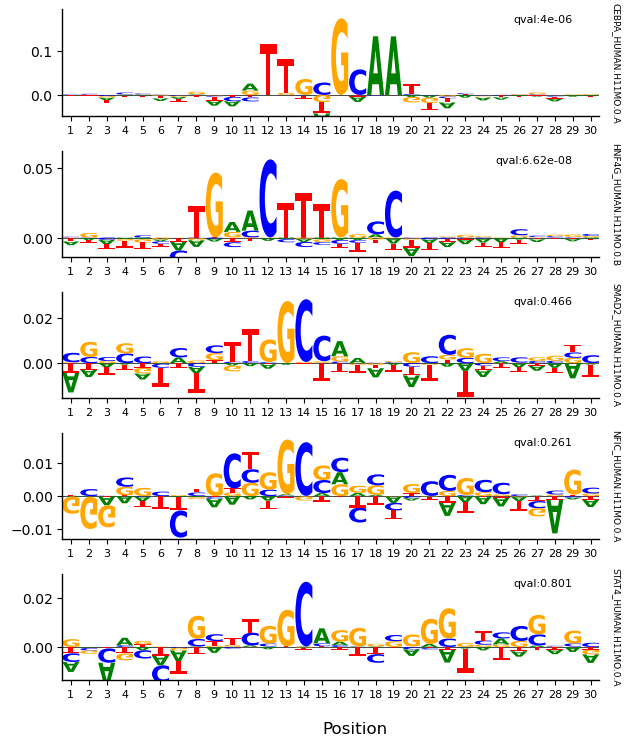

In [16]:
'''
Specify the motifs you want to plot (by Tomtom match name), or set to None to plot all
motifs_to_plot = ["motif_name_1", "motif_name_2", "motif_name_3"]
>> Use top match (match 0)

# Use second best match (match 1): (OPTIONAL)
def get_second_tomtom_match(tomtom_file):
   return get_top_tomtom_match(tomtom_file, match_index = 1)
motifs_to_plot = [get_second_tomtom_match(os.path.join(tomtom_dir,f"pos_patterns.pattern_{i}.tomtom.tsv")) for i in range(len(h5.File(hdf5_file,'r')['pos_patterns']))]
motifs_to_plot = [m for m in motifs_to_plot if m is not None] # remove None entries
'''

SAVE           = True
tomtom_dir     = f"{OUTPUT_DIR}/tomtom"
motifs_to_plot = None
pattern_type   = 'pos_patterns'

with h5.File(MODISCO_H5PY, 'r') as hf:

   print("Gathering data from HDF5 file: ", MODISCO_H5PY)

   # Extract and plot motifs
   try:
      p_motifs, p_seqlet_counts, p_qvalues, p_cwms = extract_motif_data(hf, 'pos_patterns', tomtom_dir, motifs_to_plot)
   except KeyError:
      p_motifs, p_seqlet_counts, p_qvalues, p_cwms = [], [], [], []

   try:  
      n_motifs, n_seqlet_counts, n_qvalues, n_cwms = extract_motif_data(hf, 'neg_patterns', tomtom_dir, motifs_to_plot)
   except KeyError:
      n_motifs, n_seqlet_counts, n_qvalues, n_cwms = [], [], [], []

   motifs         = p_motifs + n_motifs
   seqlet_counts  = p_seqlet_counts + n_seqlet_counts
   qvalues        = p_qvalues + n_qvalues
   cwms           = p_cwms + n_cwms

   # Plot found denovo motifs
   plot_motif_cwms(motifs, cwms, qvalues, OUTPUT_DIR, 5)

* stacked barchart of seqlet proportions

Gathering data from HDF5 file:  /net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/MORALE/multi-species/4_manuscript_figure_and_table_notebooks/Fig_comparing-similarity-between-attribtuions/../../plots/crested/modisco_Baseline_CEBPA_hg38.h5


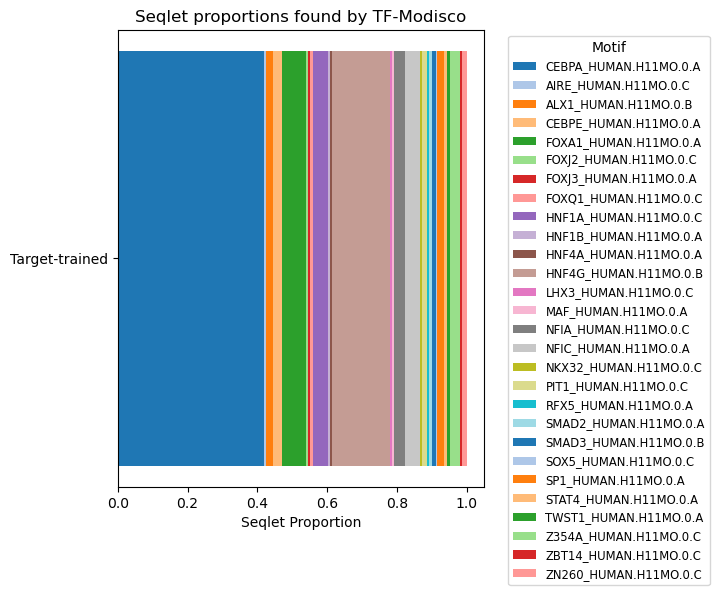

In [21]:
SAVE        = True
MODEL_NAMES = {
    f"Baseline": "Target-trained"
}

motifs         = {}
seqlet_counts  = {}
qvalues        = {}
cwms           = {}
for model_name in ["Baseline"]:

   motifs_to_plot = None
   with h5.File(MODISCO_H5PY, 'r') as hf:

      print("Gathering data from HDF5 file: ", MODISCO_H5PY)

      # Extract and plot motifs
      try:
         p_motifs, p_seqlet_counts, p_qvalues, p_cwms = extract_motif_data(hf, 'pos_patterns', TOMTOM_TSVS, motifs_to_plot)
      except KeyError:
         p_motifs, p_seqlet_counts, p_qvalues, p_cwms = [], [], [], []

      try:  
         n_motifs, n_seqlet_counts, n_qvalues, n_cwms = extract_motif_data(hf, 'neg_patterns', TOMTOM_TSVS, motifs_to_plot)
      except KeyError:
         n_motifs, n_seqlet_counts, n_qvalues, n_cwms = [], [], [], []

      motifs[model_name]         = p_motifs + n_motifs
      seqlet_counts[model_name]  = p_seqlet_counts + n_seqlet_counts
      qvalues[model_name]        = p_qvalues + n_qvalues
      cwms[model_name]           = p_cwms + n_cwms

plot_stacked_bar(motifs, seqlet_counts, ROOT_MODISCO)

-----